<div align="center"><font size=6>More Reinforcement Learning Fun</font></div>

Here we continue with more RL and maze fun, in preparation for assigment A7.

Let's develop some useful functions for learning to solve a maze.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

Our maze with be square with the same number of rows as columns.  With size of 16, we will have 14 rows and columns in our maze, inside the outer walls.

In [3]:
size = 16

Let's build our walls by defining horizontal walls as 

        (row, (beginning column, ending column)
    
and vertical walls as 

        ((beginning row, ending row), column)
        
Our walls will be a list of such items.

In [4]:
n = size - 1
walls = [[0, (0, n)],  # bottom wall
         [n, (0, n)],  # top wall
         [(0, n), 0],  # left wall
         [(0, n), n],  # right wall

         [(3, 9), 9],  # box right wall
         [(3, 9), 2],  # box bottom wall
         [9, (4, 8)],  # box top wall
         [3, (3, 8)],  # box bottom wall
         [(4, 12), 12]] # additional vertical wall

Now we can place the goal inside the box.

In [5]:
goal = np.array([6, 6])

Our actions will be steps up, down, left, or right.  We can code them as increments or decrements to the row and column values of our position.

In [6]:
actions = [(1, 0),   # up
           (-1, 0),  # down
           (0, -1),  # left
           (0, 1)]   # right

Now we need some functions to do things like
* determine if we have hit a wall, ```hit_walls(position)```
* apply an action to our position, ```take_action(position, actioni)```
* randomly pick a starting position, ```pick_random_position(position, actioni)```
* pick an action based on Q values, ```pick_action(Q, position)```

In [7]:
def hit_walls(position, walls):
    r, c = position    # r is position row, c is position column
    for wall in walls:
        if isinstance(wall[0], int):
            # horizontal
            row = wall[0]
            cols = wall[1]
            if r == row and cols[0] <= c <= cols[1]:
                return True
        else:
            # vertical wall
            rows = wall[0]
            col = wall[1]
            if c == col and rows[0] <= r <= rows[1]:
                return True
    return False

print(hit_walls((1, 1), walls))
for p in [(1, 1), (5, 5), (0, 0), (9, 5), (8, 5)]:
    print('Position', p, 'hit_walls=', hit_walls(p, walls))

False
Position (1, 1) hit_walls= False
Position (5, 5) hit_walls= False
Position (0, 0) hit_walls= True
Position (9, 5) hit_walls= True
Position (8, 5) hit_walls= False


In [8]:
def take_action(position, actioni):
    action = actions[actioni]
    next_position = [position[0] + action[0],
                     position[1] + action[1]]
    return np.clip(next_position, 0, size - 1)

[3, 2]
for actioni in range(4):
    print('Position', p, end='')
    print(' action', actioni, actions[actioni], end='')
    p = take_action(p, actioni)
    print(' takes us to position', p)

Position (8, 5) action 0 (1, 0) takes us to position [9 5]
Position [9 5] action 1 (-1, 0) takes us to position [8 5]
Position [8 5] action 2 (0, -1) takes us to position [8 4]
Position [8 4] action 3 (0, 1) takes us to position [8 5]


In [9]:
def pick_random_position(walls):
    while True:
        position = np.random.randint(1, size - 2, 2)
        if not hit_walls(position, walls):
            break
    return position

for i in range(10):
    print(pick_random_position(walls))

[10  8]
[11 11]
[2 8]
[9 1]
[12  5]
[4 7]
[4 3]
[2 1]
[7 6]
[10 11]


To pick an action, we need our Q function, represented as a table like last time.

In [10]:
Q = np.zeros((size, size, 4))

In [11]:
def pick_action(Q, position):
    row, col = position
    Qs = Q[row, col, :]
    return np.argmin(Qs)

actioni = pick_action(Q, [1, 1])
actioni, actions[actioni]

(0, (1, 0))

To start our main training loop, we need a starting position and action from that position, and initial, empty, lists to keep traces of positions and reinforcements, to be used to display our progress.

Then, we can start our loop, which consists of these steps:

1. Apply action to position to get next position.
2. If we just hit a wall, set Q value of previous position to a large number, like 500, to avoid ever taking this action again.  Go back to previous position and pick another action.
3. If we just found the goal, set Q value of previous position to 1, because it took just one step to reach the goal from that previous position.  Pick a new starting position and action.
4. Otherwise, pick action to take for next position, calculate the TD error between Q value at next position and action, and previous position and action, plus r of 1. Update Q value at previous position and action according to the TD error.
5. Copy next position to position, and next_action to action variables.
6. Repeat!

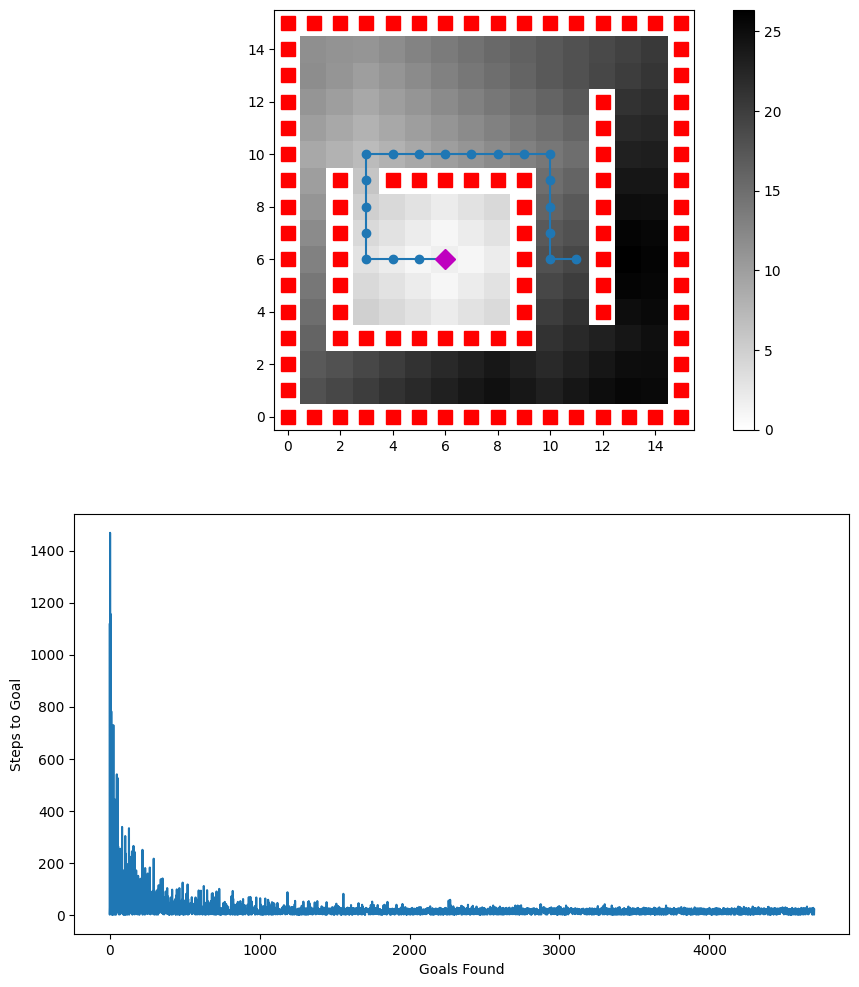

In [12]:
fig = plt.figure(figsize=(10, 12))

n_steps = 100_000
learning_rate = 0.2

Q = np.zeros((size, size, 4))

position = pick_random_position(walls)
actioni = pick_action(Q, position)

n_goals = 0
steps_to_goal = []
last_path = []
starting_step = 0
goal_found = False

for step in range(n_steps):

    if goal_found:
        last_path = []
        goal_found = False
        
    next_position = take_action(position, actioni)
    last_path.append(next_position)
    
    if hit_walls(next_position, walls):
        row, col = position
        Q[row, col, actioni] = 500  # Make Q so high this action never selected again.
        last_path.append(position)
        actioni = pick_action(Q, position)
        
    elif np.all(next_position == goal):
        # Found goal
        goal_found = True
        n_goals += 1
        r = 1
        row, col = position
        Q[row, col, actioni] = r  # No future. Just found the goal.
        # Start at new random position
        position = pick_random_position(walls)
        actioni = pick_action(Q, position)
        steps_to_goal.append(step - starting_step)
        starting_step = step

    else:
        # Take one step to get next_Q at next position to make TD error
        r = 1
        next_actioni = pick_action(Q, next_position) 
        Q_value = Q[position[0], position[1], actioni]
        next_Q_value = Q[next_position[0], next_position[1], next_actioni]
        TD_error = r + next_Q_value - Q_value
        Q[position[0], position[1], actioni] += learning_rate * TD_error

        position = next_position.copy()
        actioni = next_actioni

    if goal_found and (n_goals < 100 or n_goals % 100 == 0):
        
        fig.clf()
        
        # Draw Q function as image with walls
        image = np.min(Q[:, :, :], axis=-1)
        imagemax = np.max(image)
        vmax = imagemax if imagemax > 5 else 5
        plt.figure(1)
        plt.clf()
        plt.subplot(2, 1, 1)
        plt.imshow(image, origin='lower', cmap='binary',
                   interpolation='nearest')
        plt.colorbar()
        
        # Draw walls
        for row in range(size):
            for col in range(size):
                if hit_walls([row, col], walls):
                    plt.plot(col, row, 'rs', ms=10)

        # Draw last path
        last_path_array = np.array(last_path)
        plt.plot(last_path_array[:, 1], last_path_array[:, 0], 'o-')

        # Draw goal
        plt.plot(goal[1], goal[0], 'mD', ms=10)

        # Plot steps to goal for each path tried
        plt.subplot(2, 1, 2)
        plt.plot(steps_to_goal)
        plt.xlabel('Goals Found')
        plt.ylabel('Steps to Goal')
           
        clear_output(wait=True)
        display(fig);


clear_output(wait=True)